In [15]:
import os
import sys
import json
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *
from model_analysis import *

### Choose Data and Model to Visualize

In [2]:
data_path = "/usr/WS1/pcrom/for_Zoe/final_preprocess/specific_test"
weights_path = "weights/large_LP_1899_plus_1101.pth"

# from specific test, 10 (all test) and 17 (paper test)
sample_id = 17
weights_name = "large_LP_3000"

### Load in Data

In [3]:
path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path

# Add the root directory (PARCTorch) to the system path
sys.path.append(path)

from data.normalization import compute_min_max

sys.path.append("/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC")

data_dirs = [data_path]
output_file = "/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)

min_max_path = os.path.join(path, "data", "hmx_min_max.json")

Calculating channel-wise min and max values for normalization...
Current working directory: /g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 98
Processed 98/98 files.
Channel-wise min values: [np.float64(324.9062805175781), np.float64(0.0), np.float64(0.0), np.float64(-0.04497837632211557), np.float64(-0.2113136996765604)]
Channel-wise max values: [np.float64(1847.19873046875), np.float64(0.3752285469213116), np.float64(1.0), np.float64(0.5678289942089401), np.float64(0.2099416389246396)]
Min and max values saved to '/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


In [4]:
# load in test dataset with full 20ts sequence
n_channels = 3
n_ts = 20

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_path], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

Listing samples: 100%|██████████| 98/98 [00:00<00:00, 1555.66it/s]


In [5]:
ic, _, ts, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
X = torch.concat((ic.unsqueeze(0), target))
print(X.shape)

torch.Size([3, 64, 160]) torch.Size([19, 3, 64, 160])
torch.Size([20, 3, 64, 160])


### Create and Load in Model

In [6]:
# define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize all elements
layer_sizes = [3, 8]
latent_dim = 8
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)

# Initialize LatentPARC
model_init = lp_model(encoder, decoder, differentiator, integrator).to(device)

# Init Optimizer
# optimizer = Adam(model_init.parameters(), lr=1e-3)
optimizer = None

# training model
model = LatentPARC(model_init, optimizer)

# load weights into model
checkpoint = torch.load(weights_path, map_location=device)

# Load model weights
model.network.load_state_dict(checkpoint["model_state_dict"])

model.network.eval()  # Set to evaluation mode

lp_model(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (differentiator): Differentiator(
    (b1c1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

### Make Predictions

In [7]:
n_channels = 3
n_ts = 20

with torch.no_grad():
    z, pred = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

z = z.squeeze(1).cpu()  # squeeze is remenant of needing to stack for rollout training
pred = pred.squeeze(1)

### Un-Normalize 

In [8]:
X_denorm = unnormalize_flexchannels(X, min_max_path, first_n_channels=3)
pred_denorm = unnormalize_flexchannels(pred, min_max_path, first_n_channels=3)

print(X_denorm.shape, pred_denorm.shape)

torch.Size([20, 3, 64, 160]) torch.Size([20, 3, 64, 160])


### Visualize Results

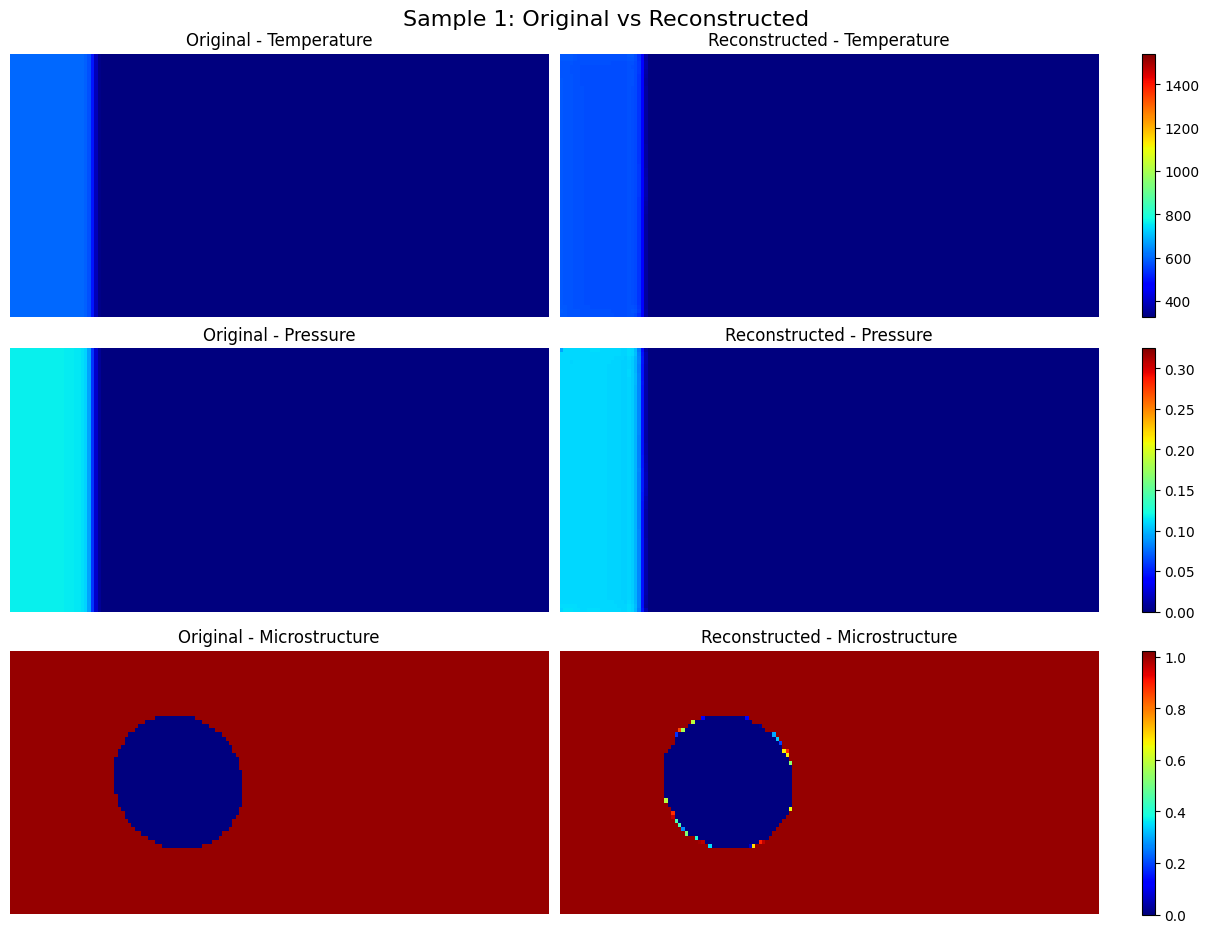

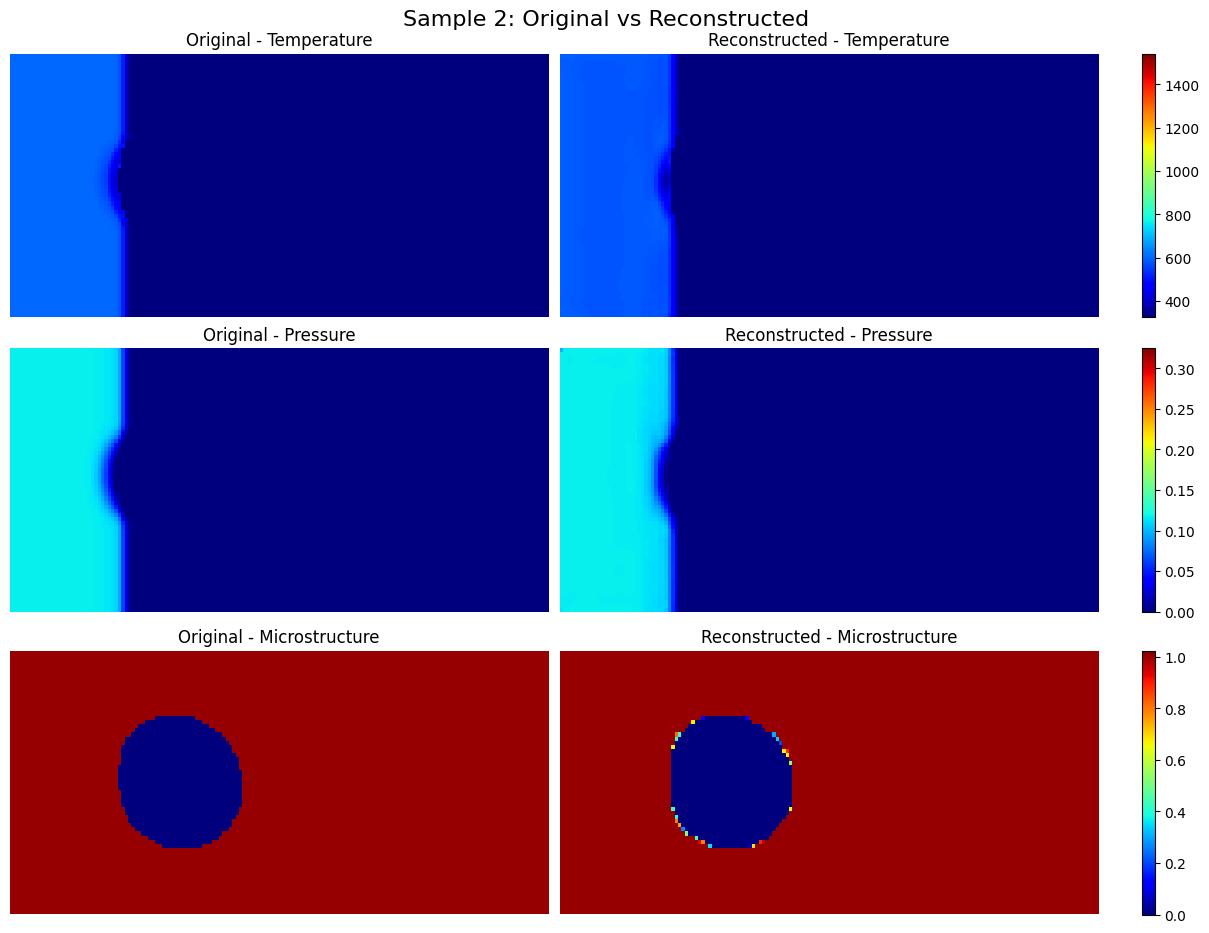

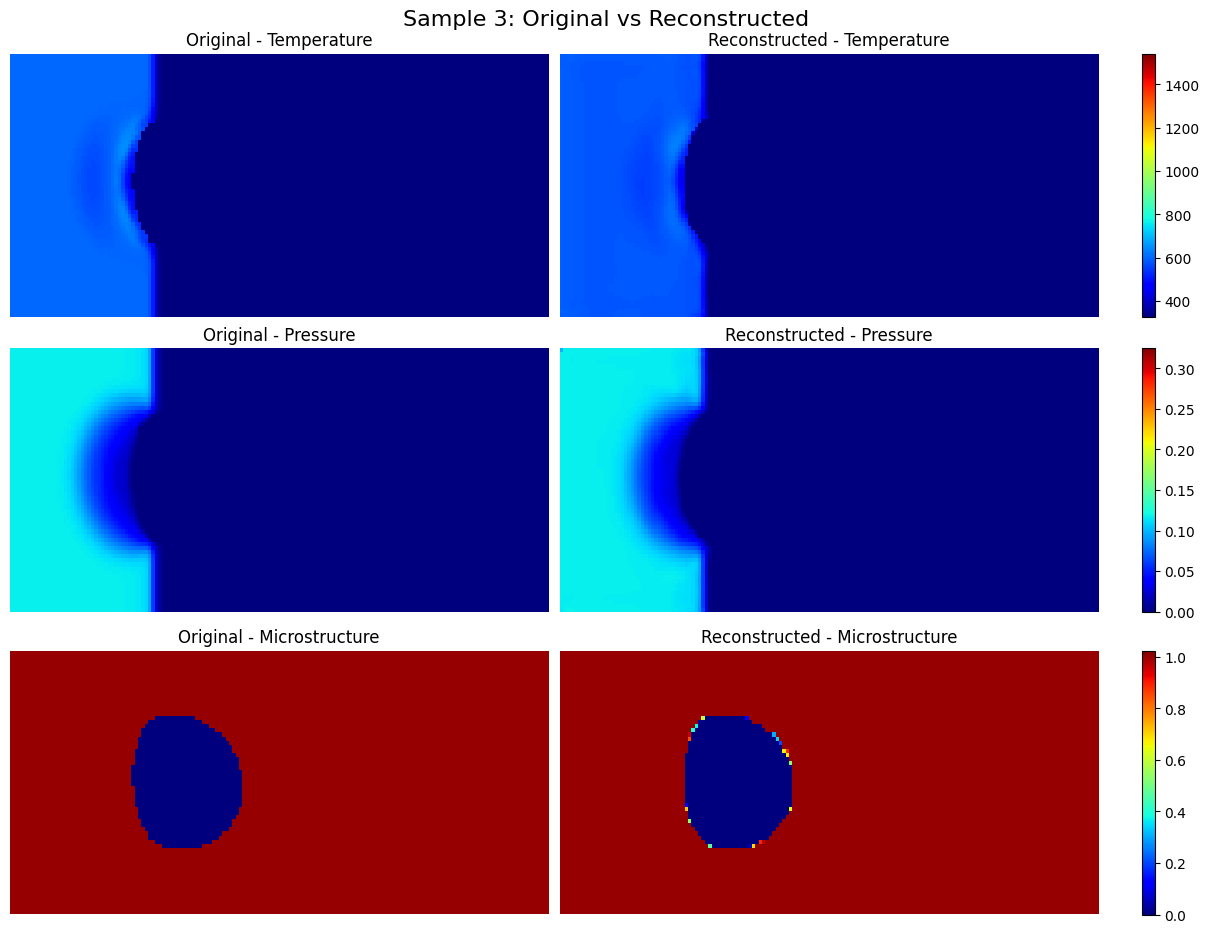

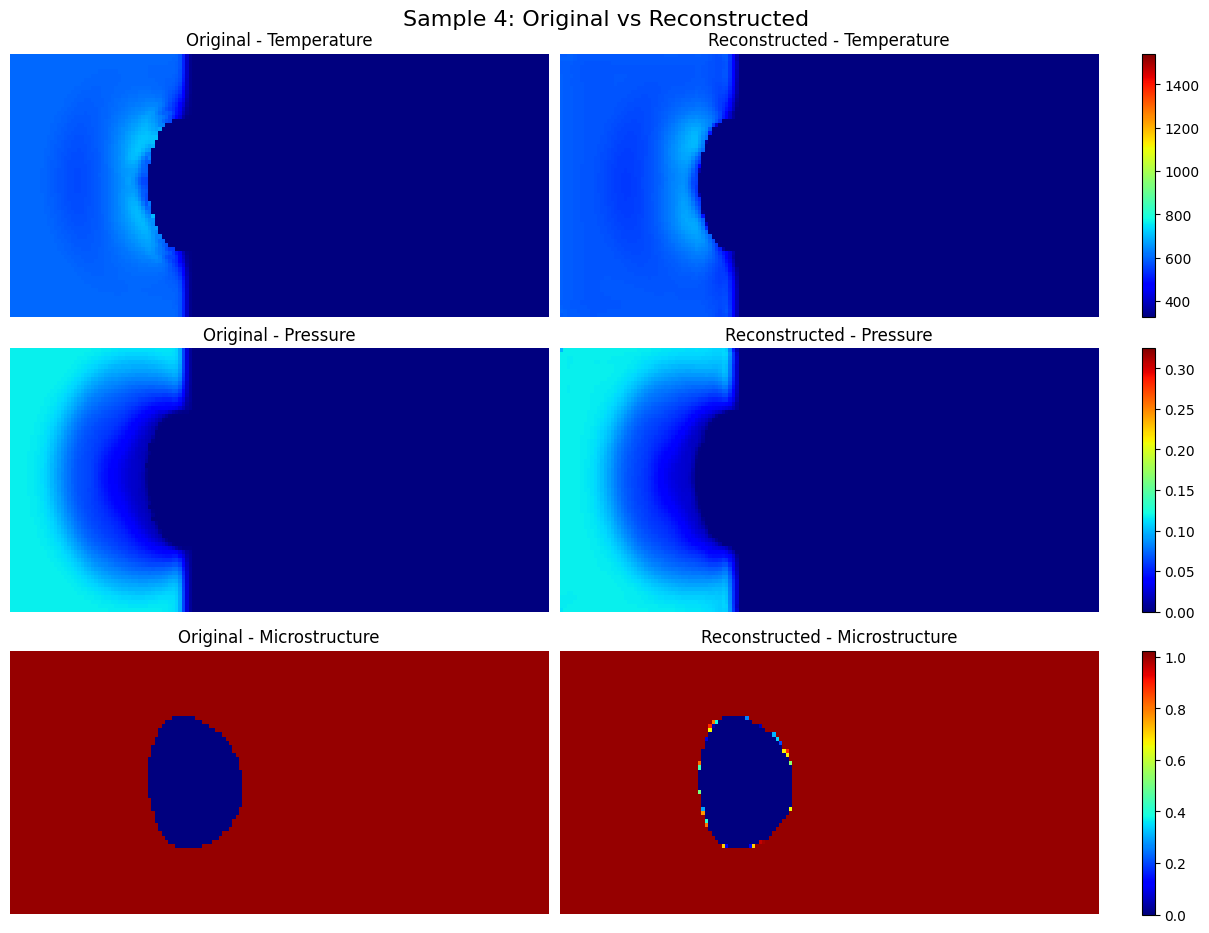

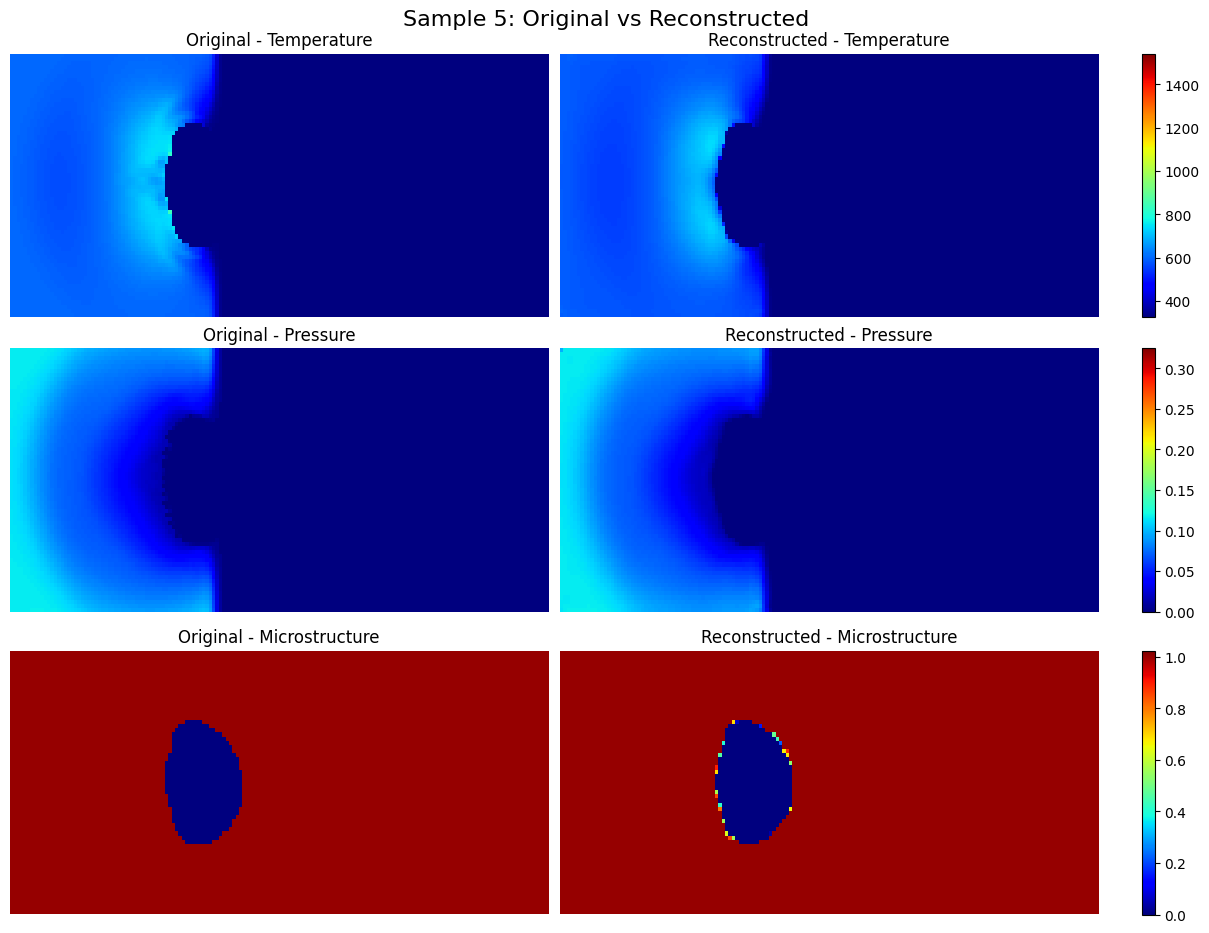

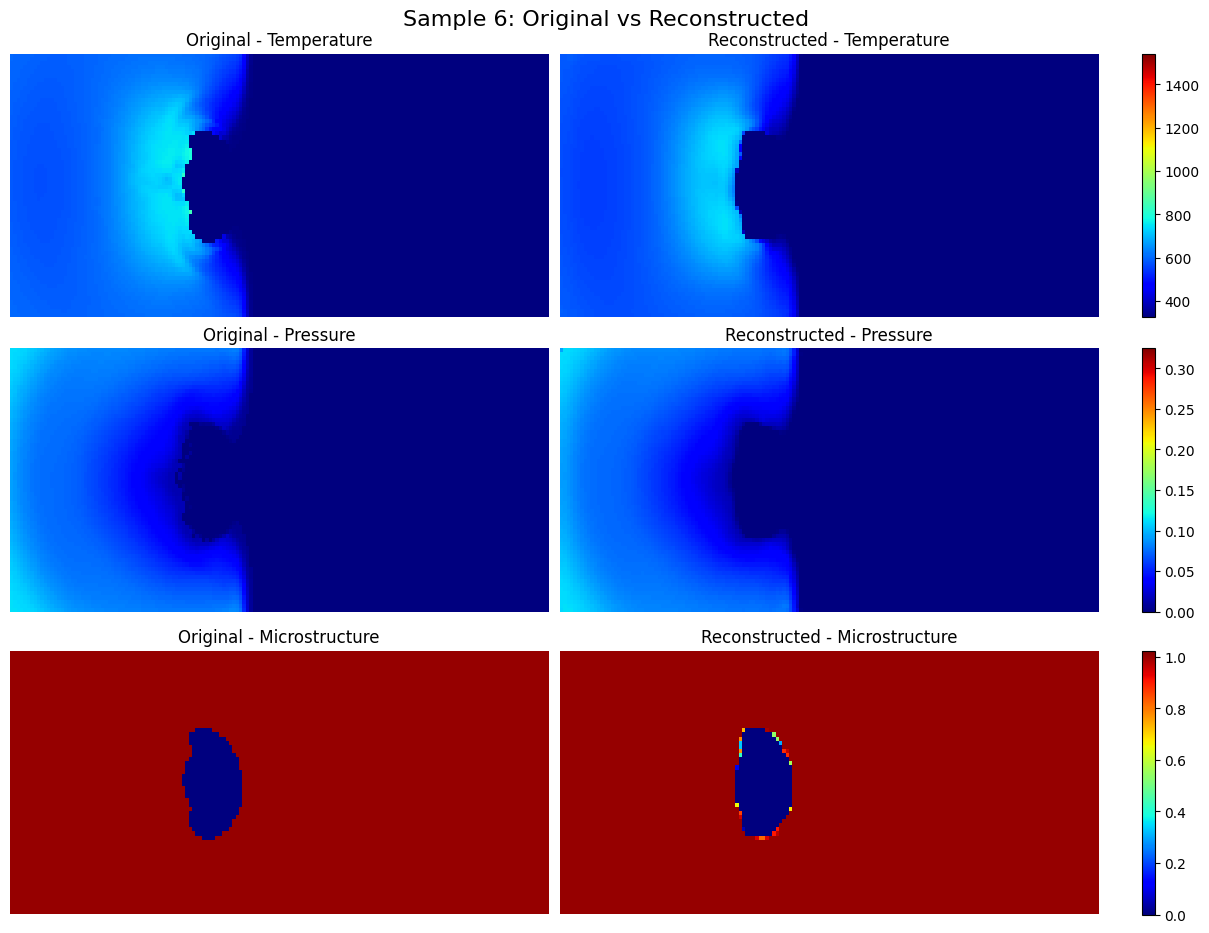

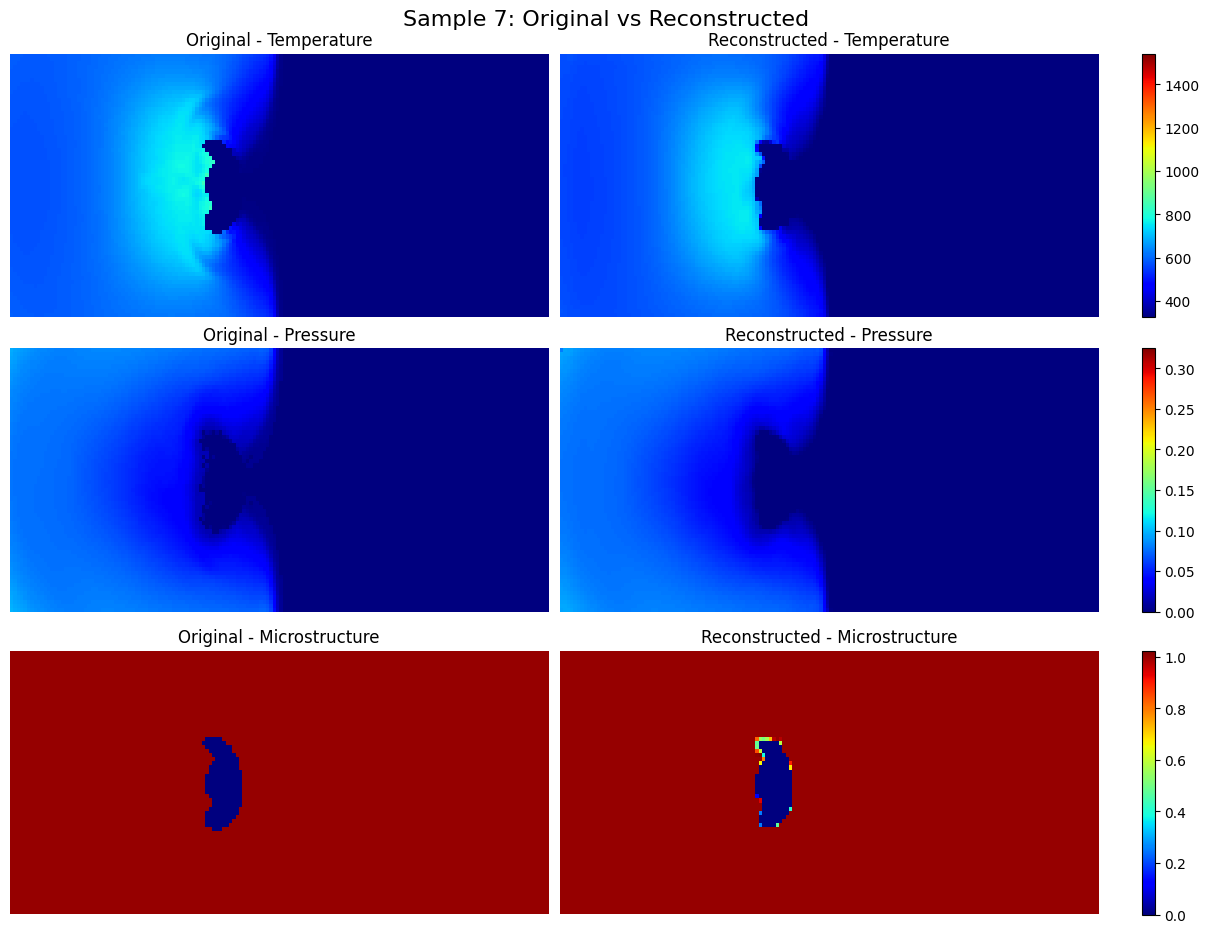

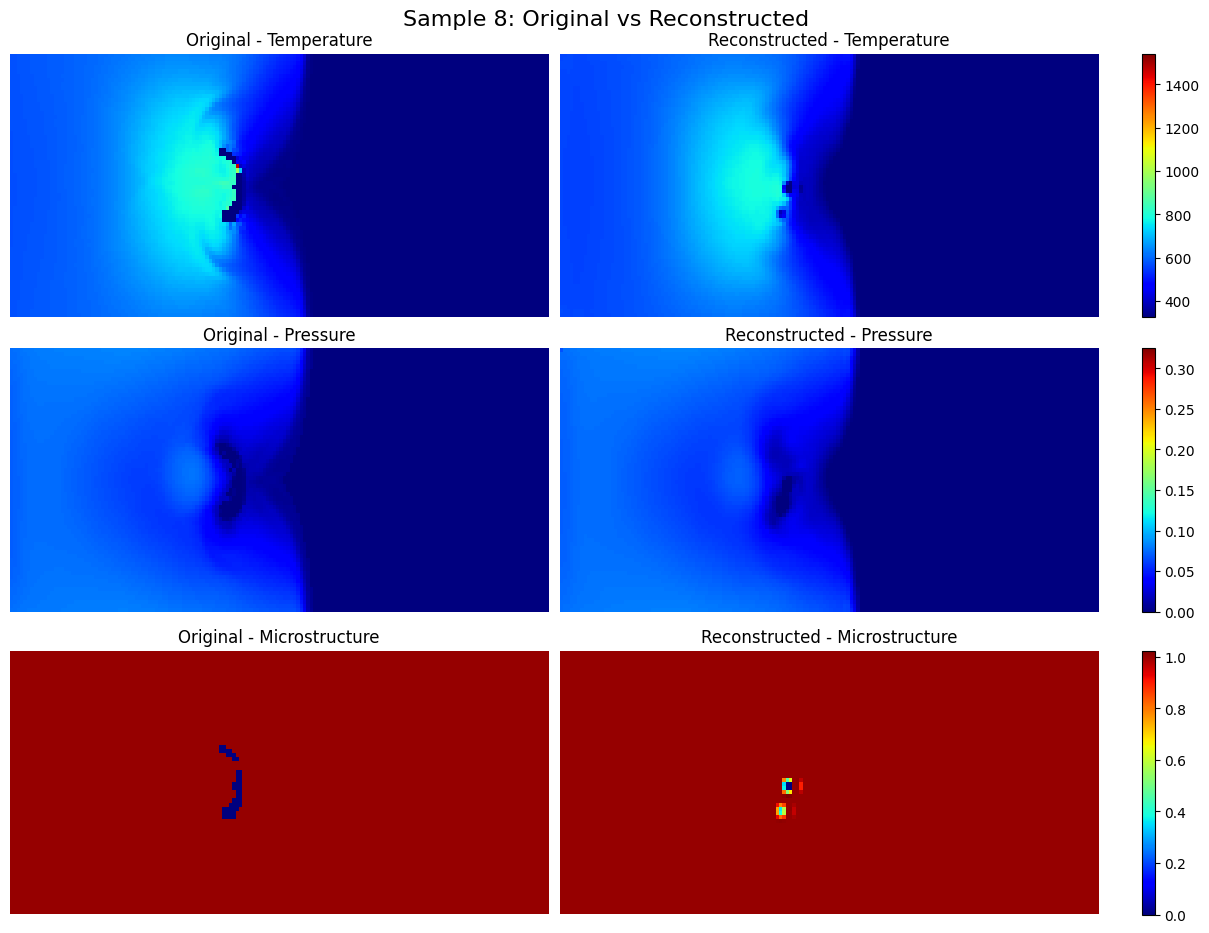

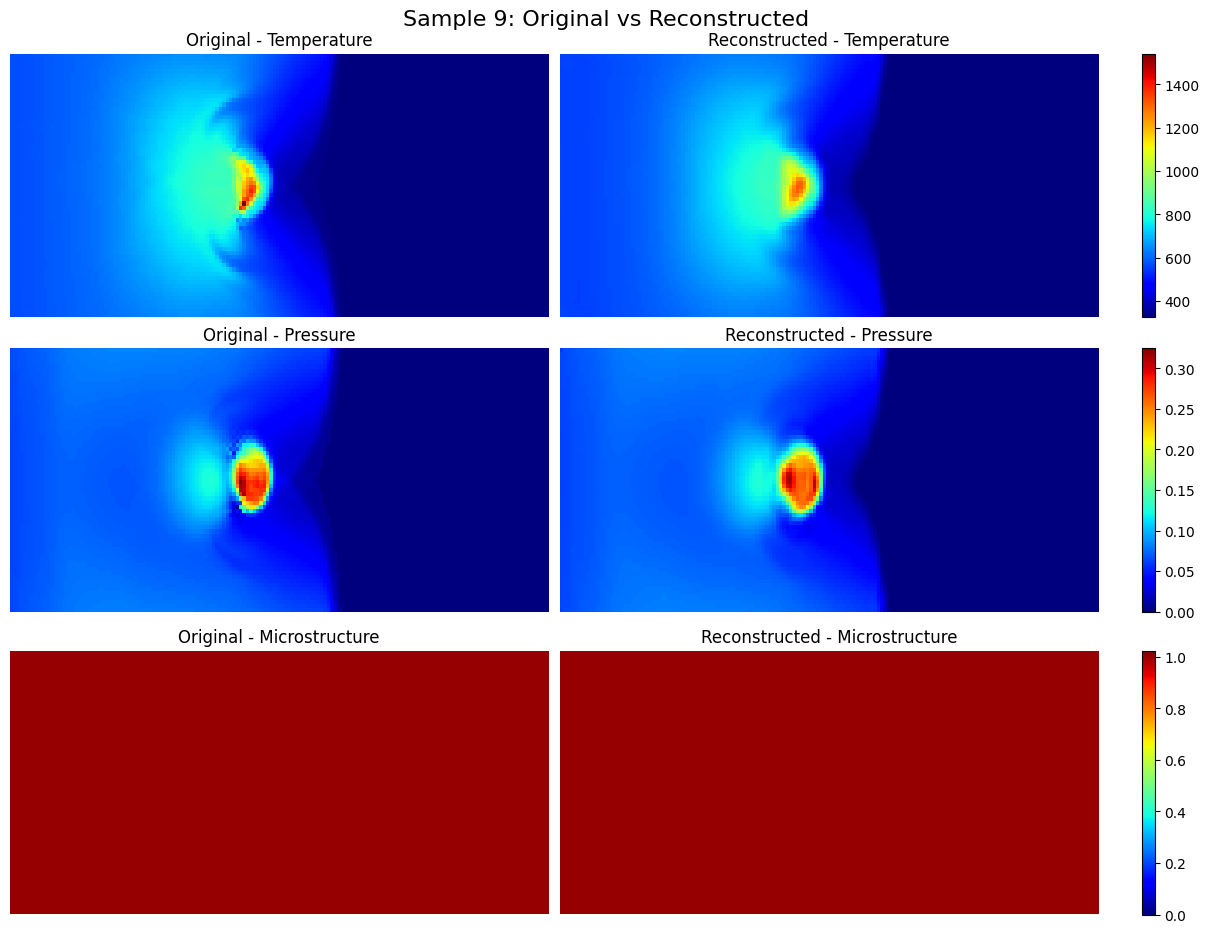

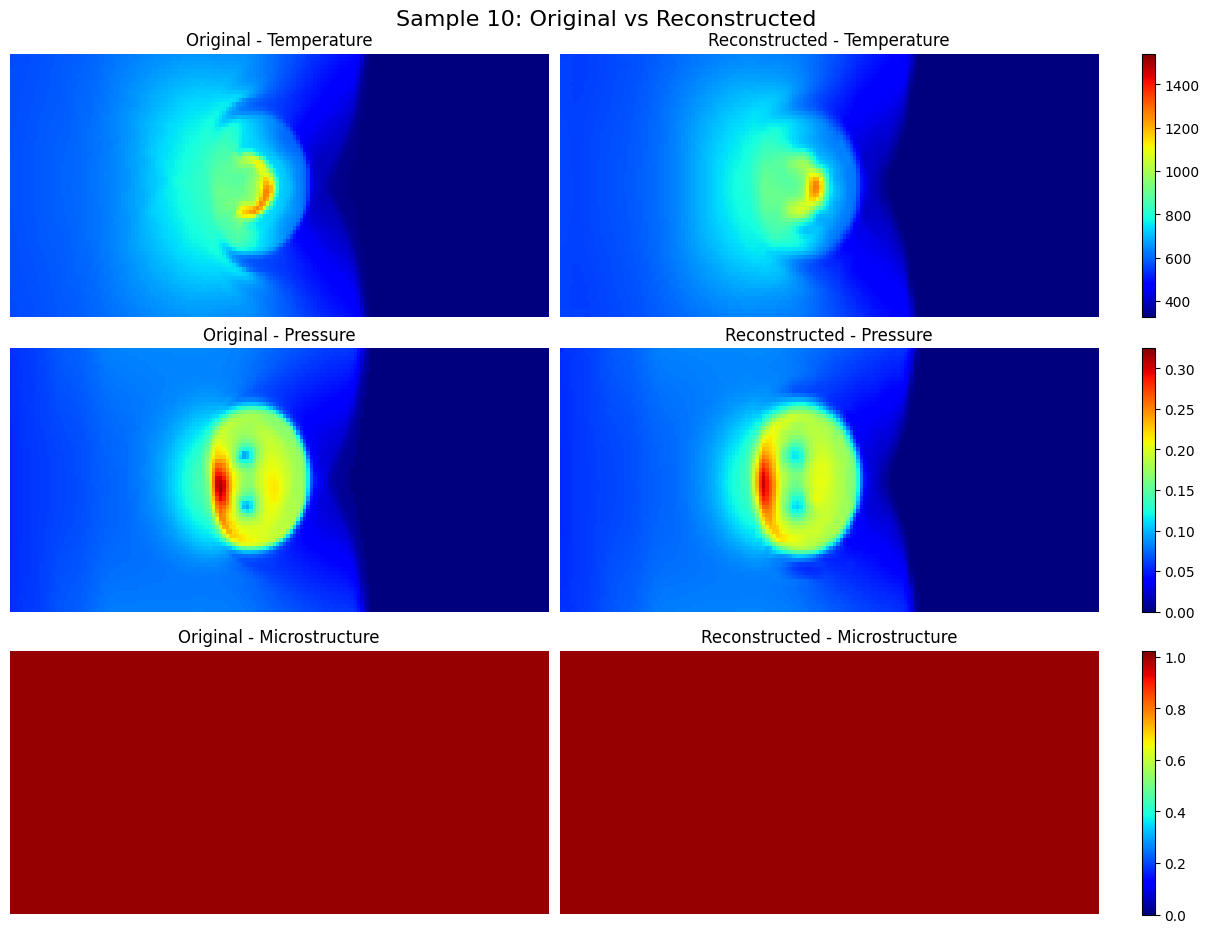

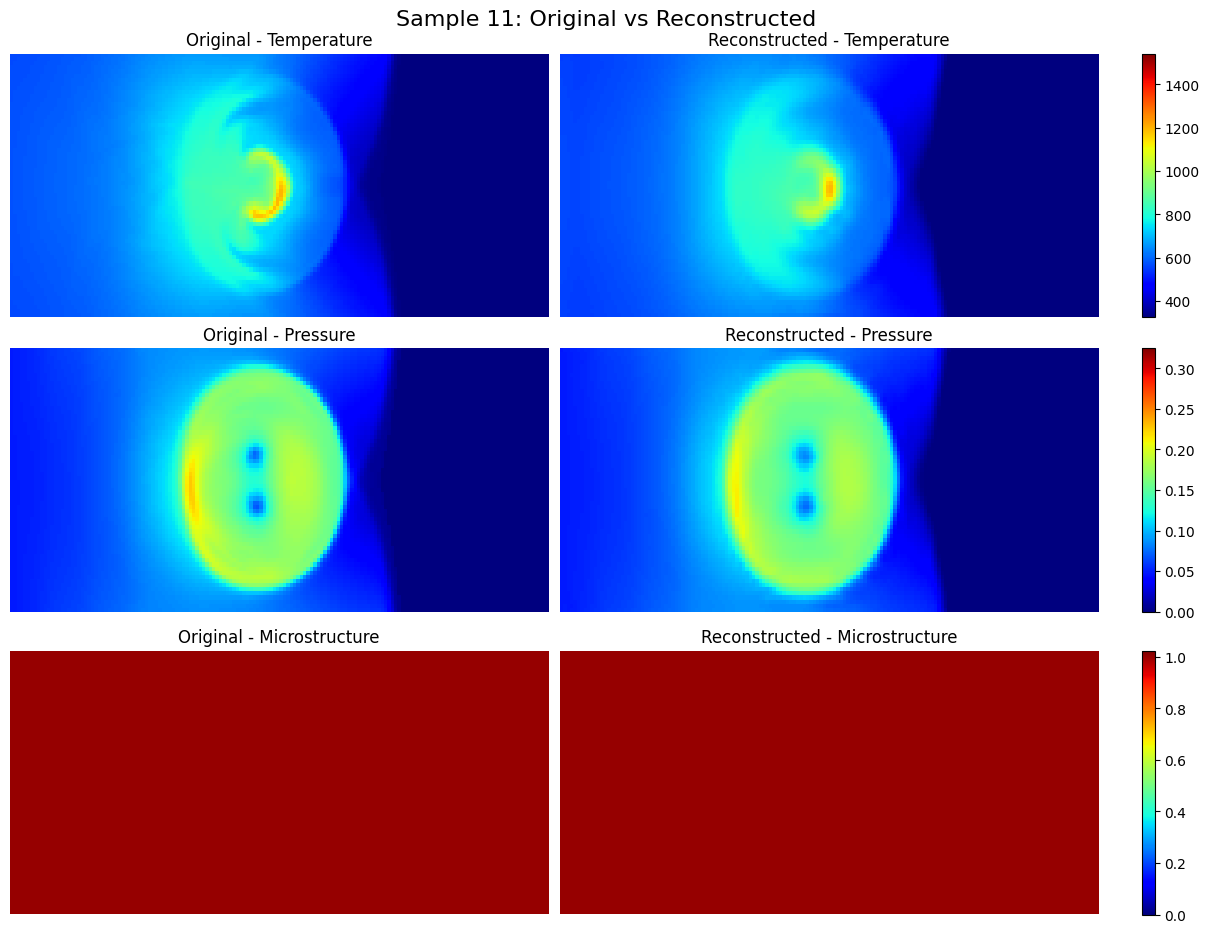

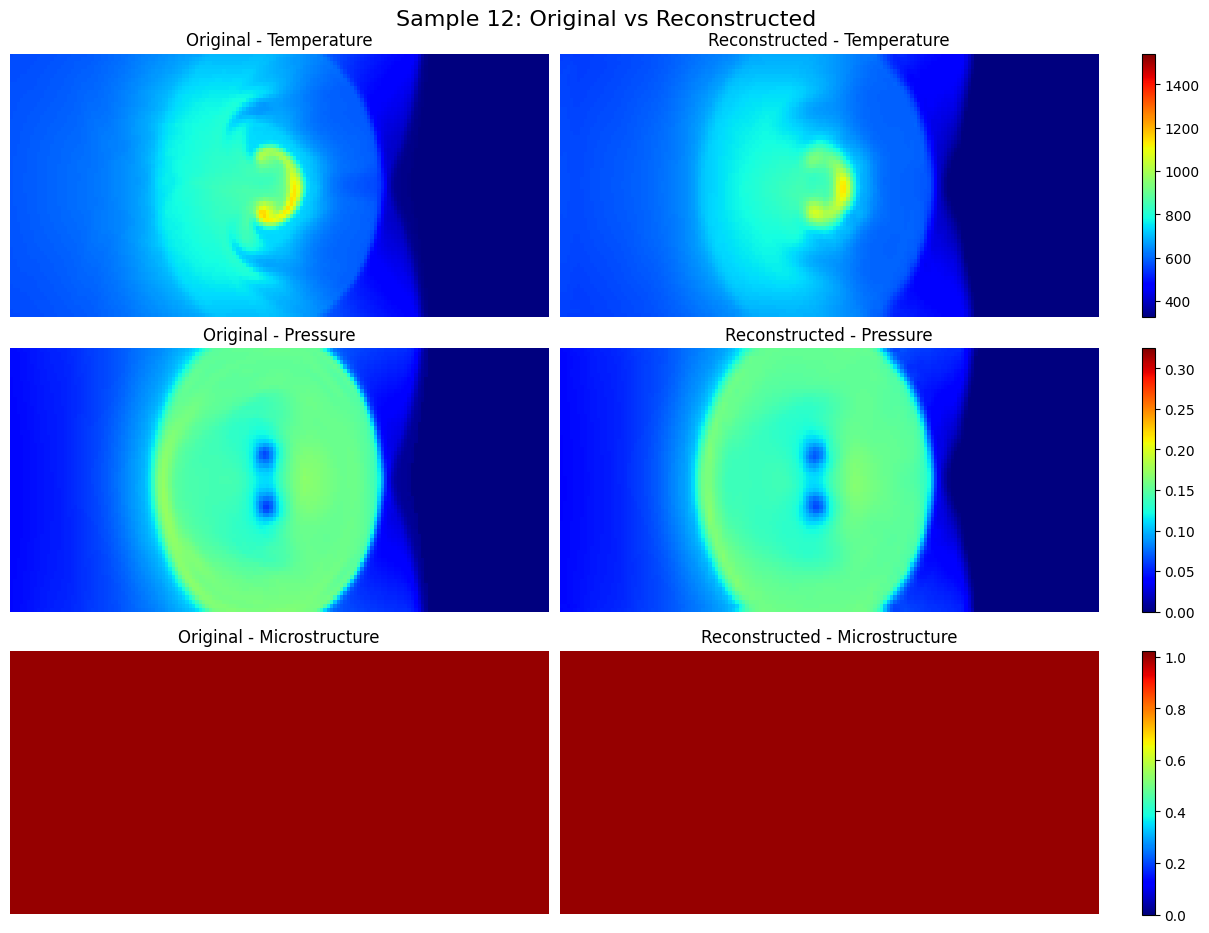

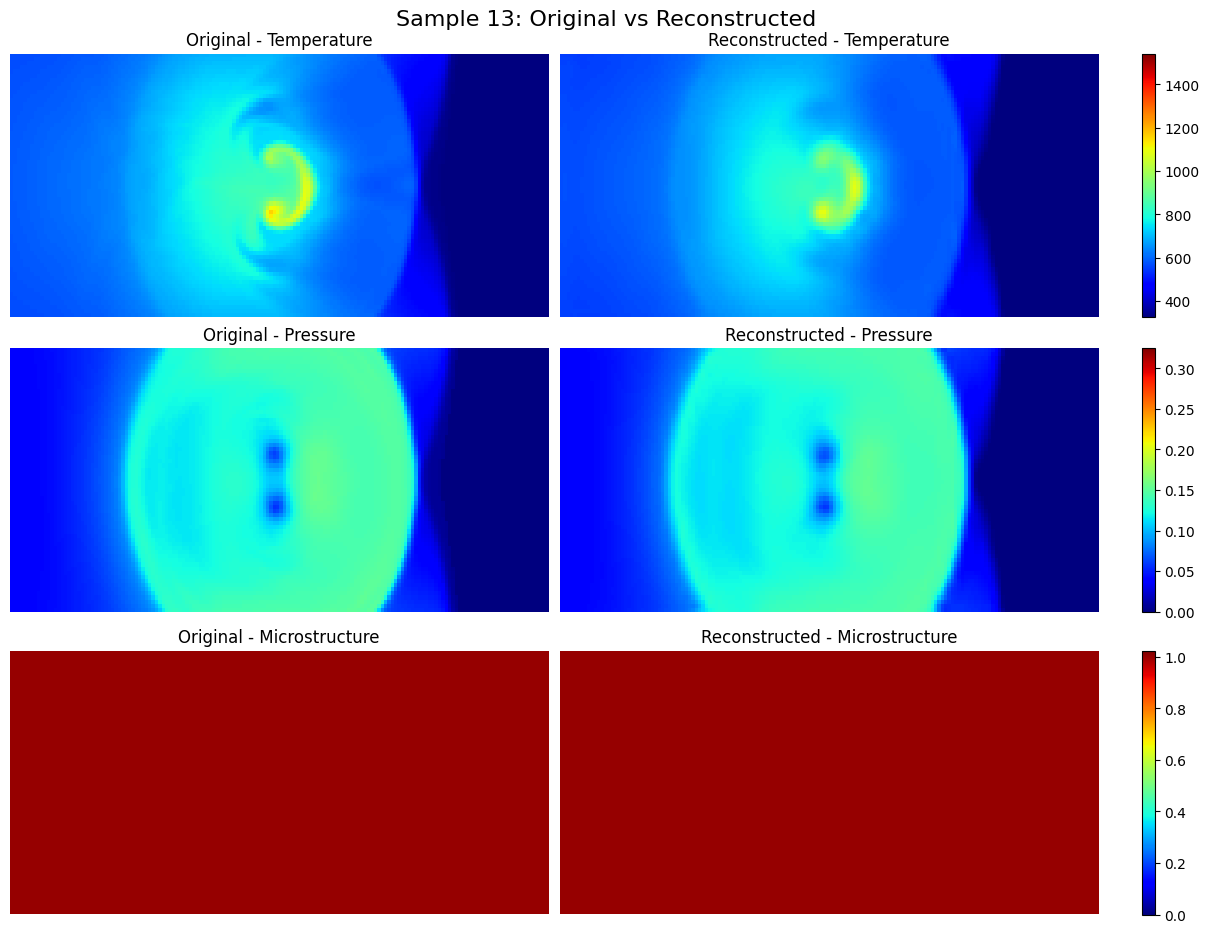

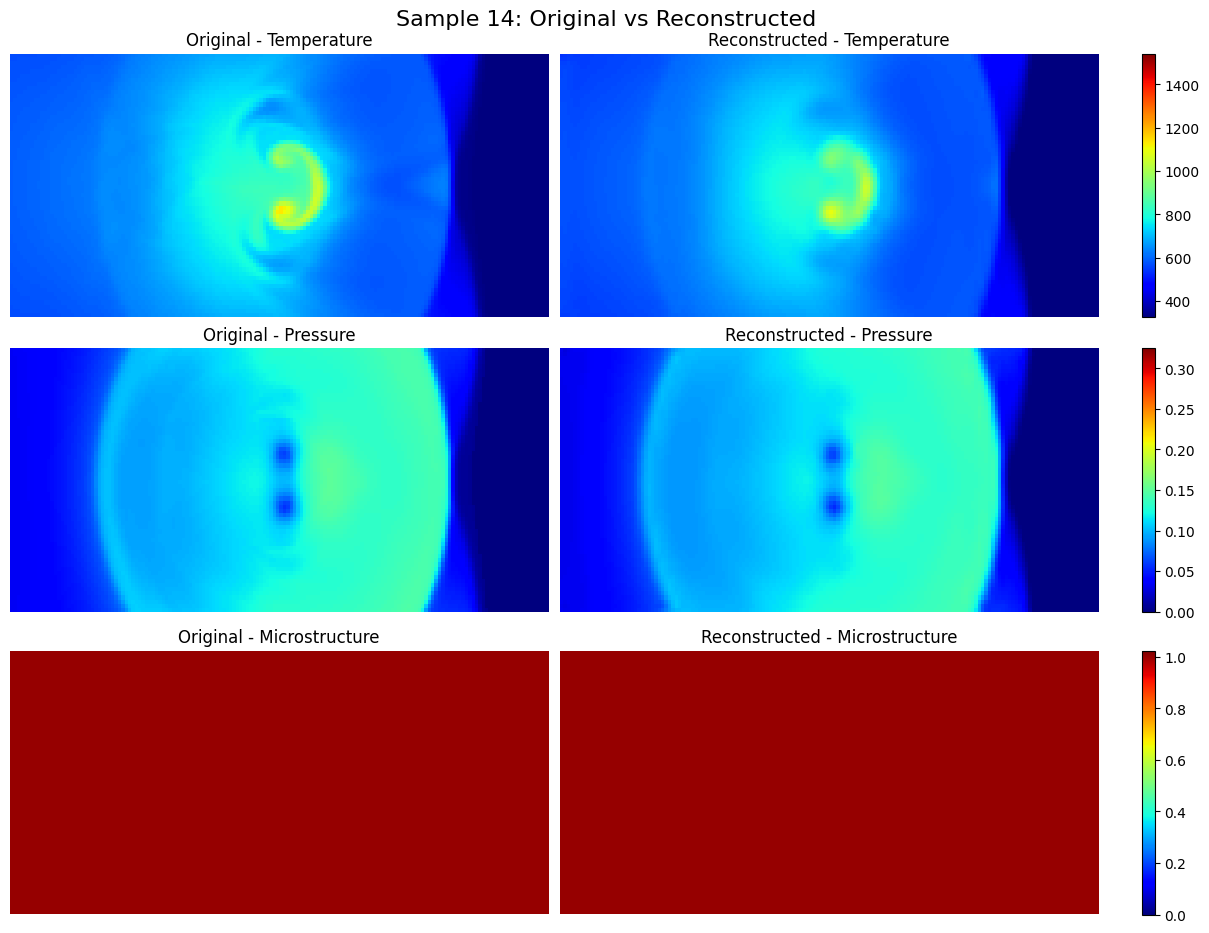

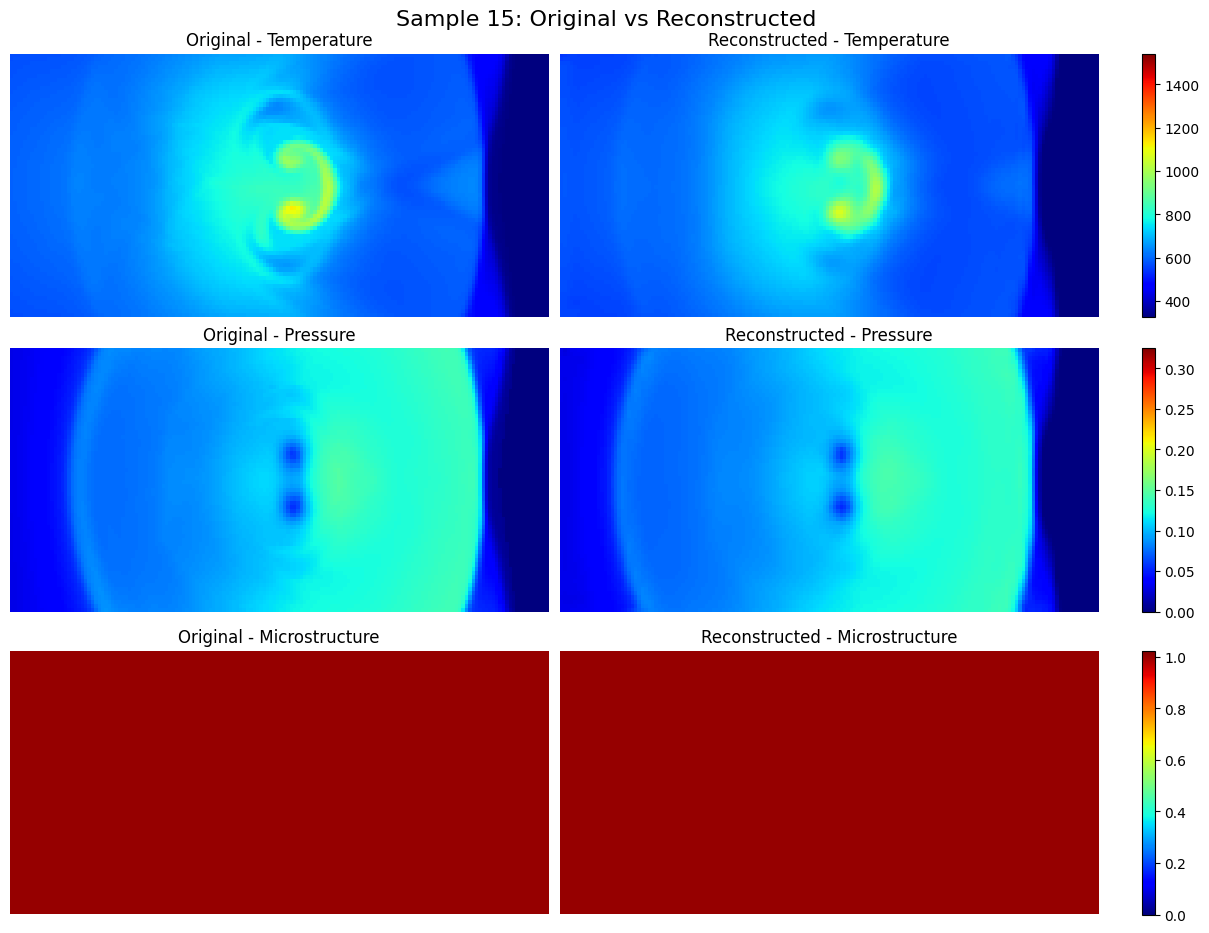

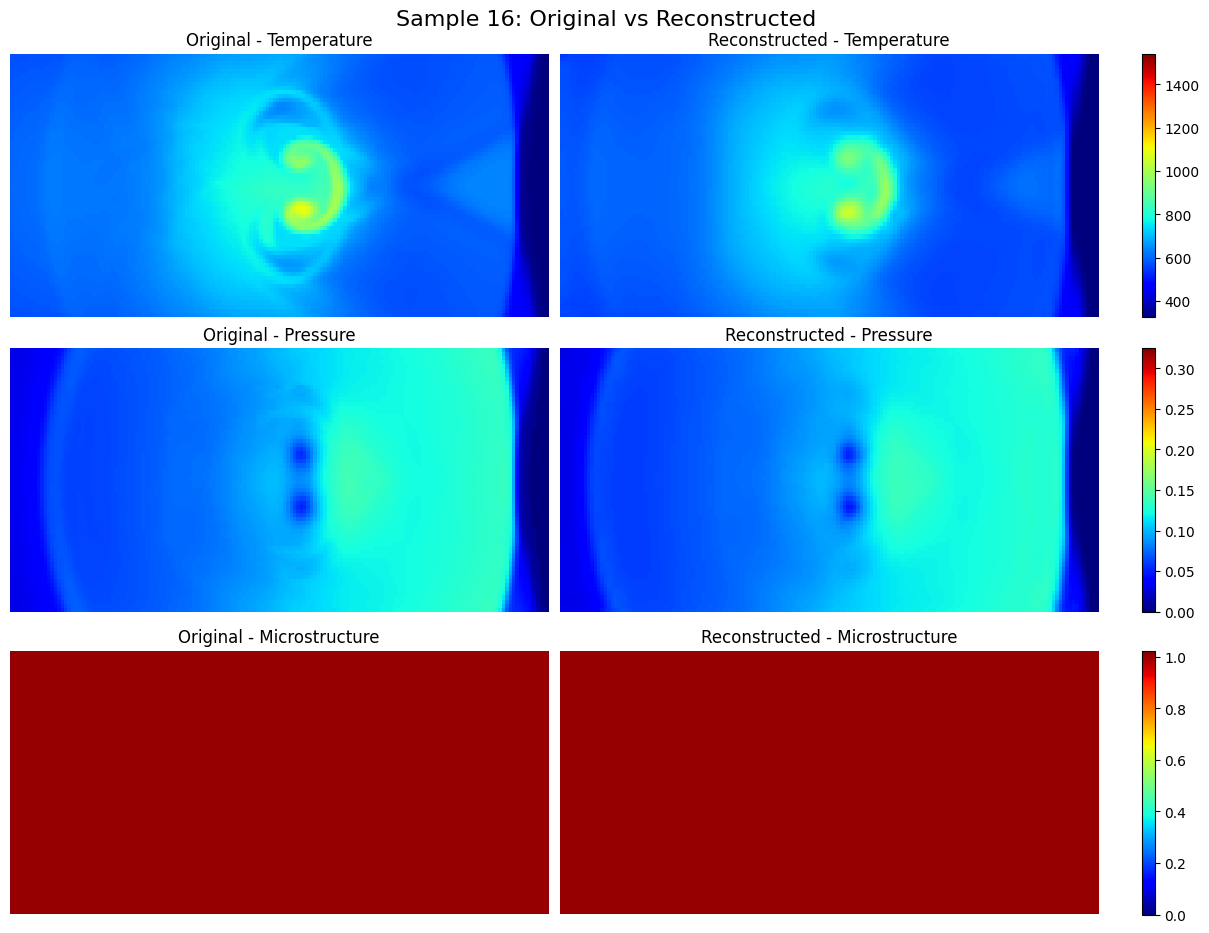

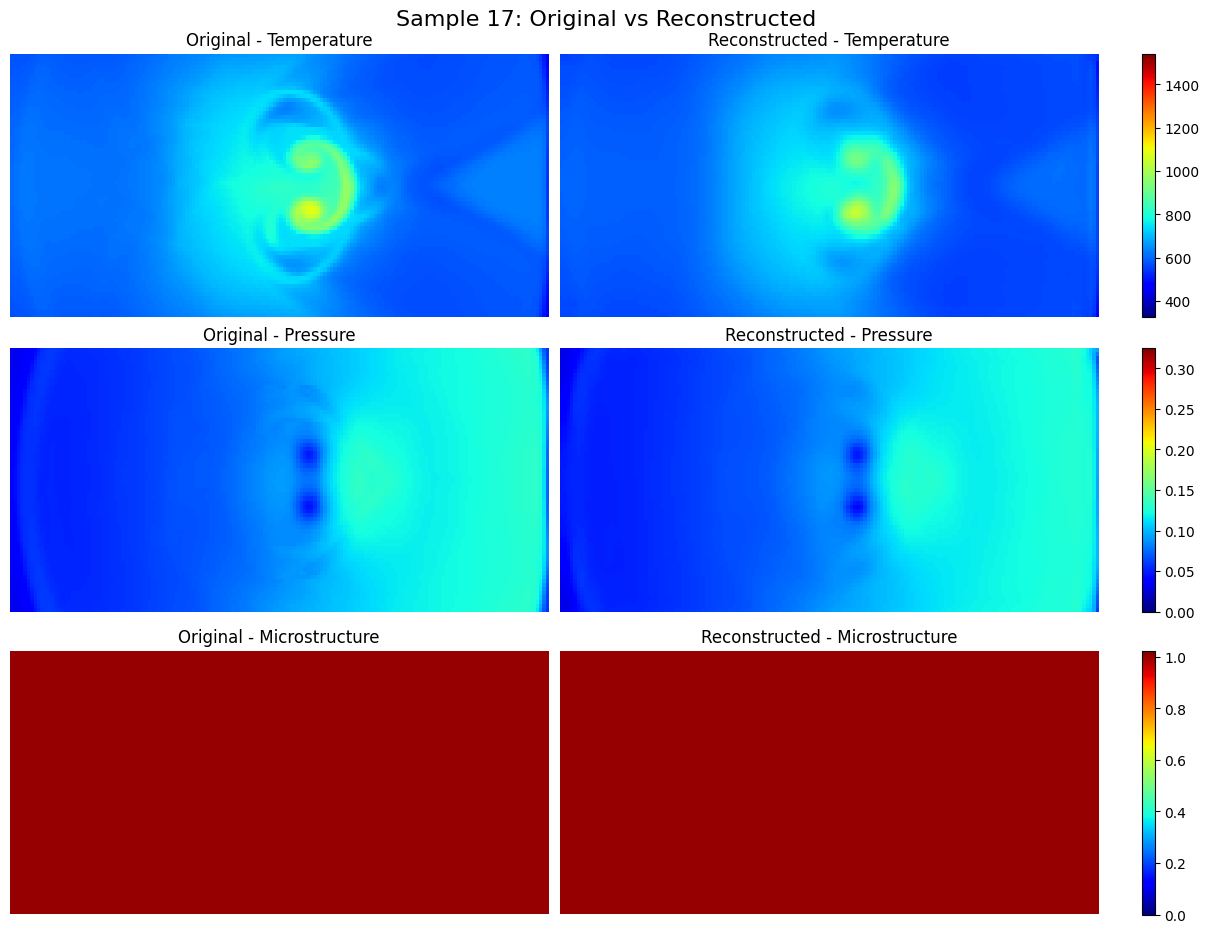

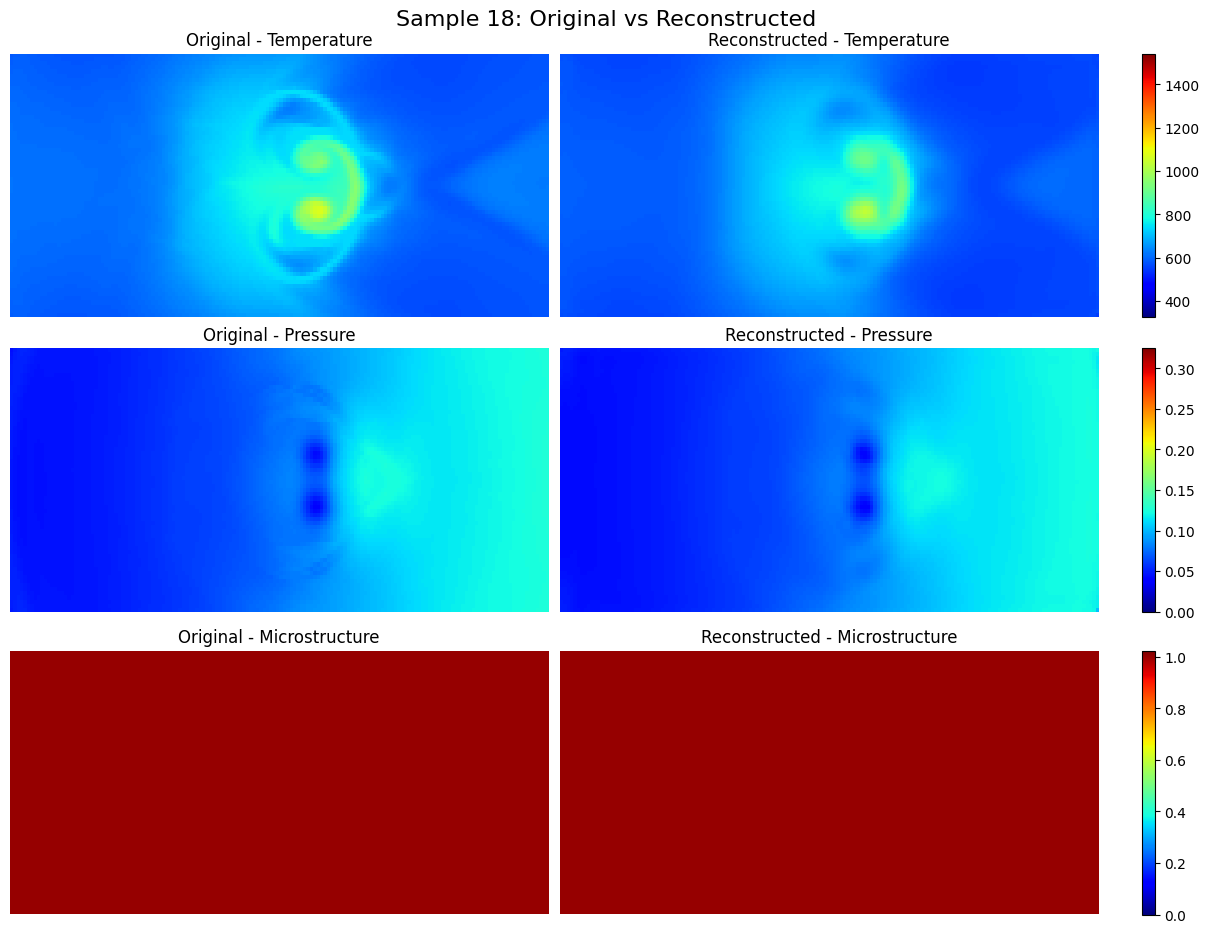

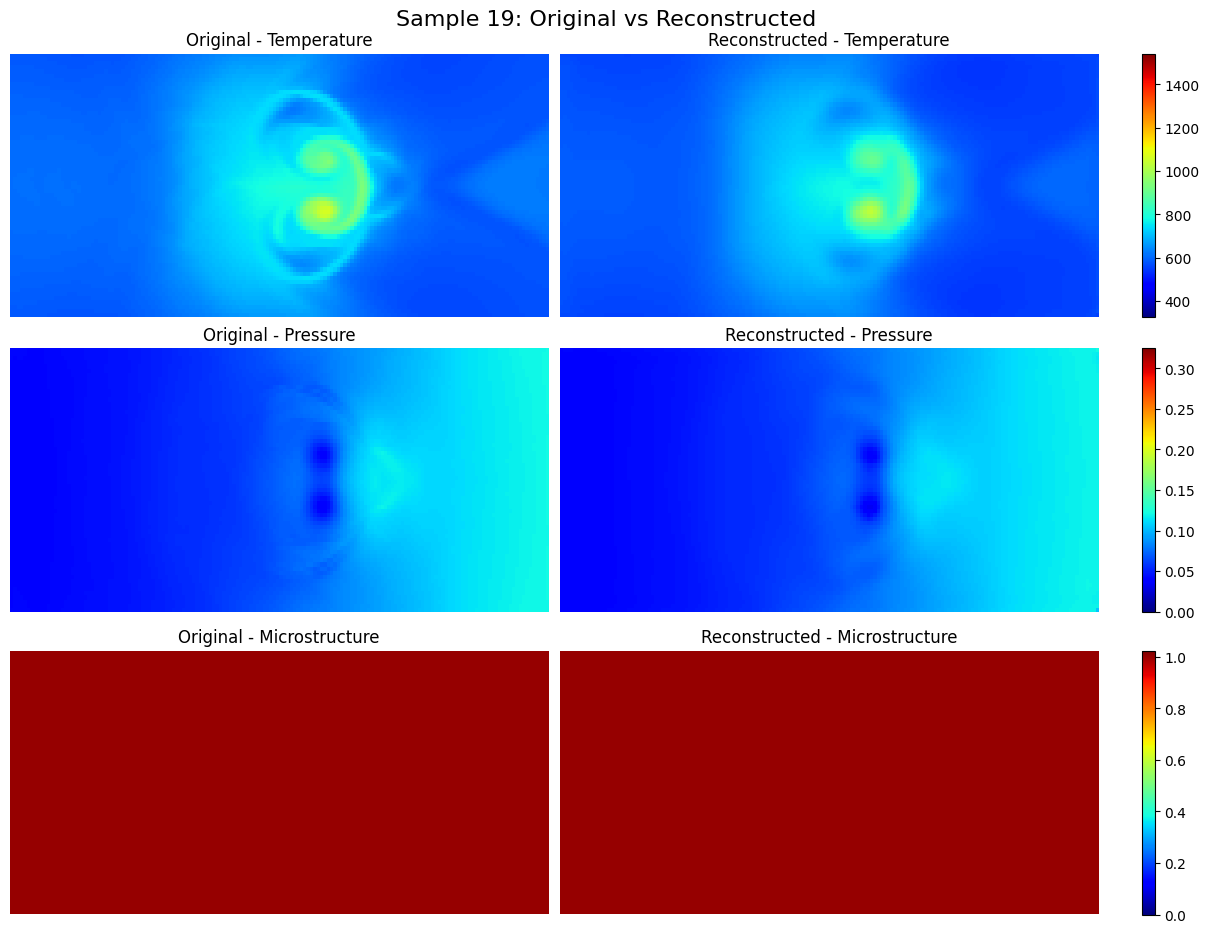

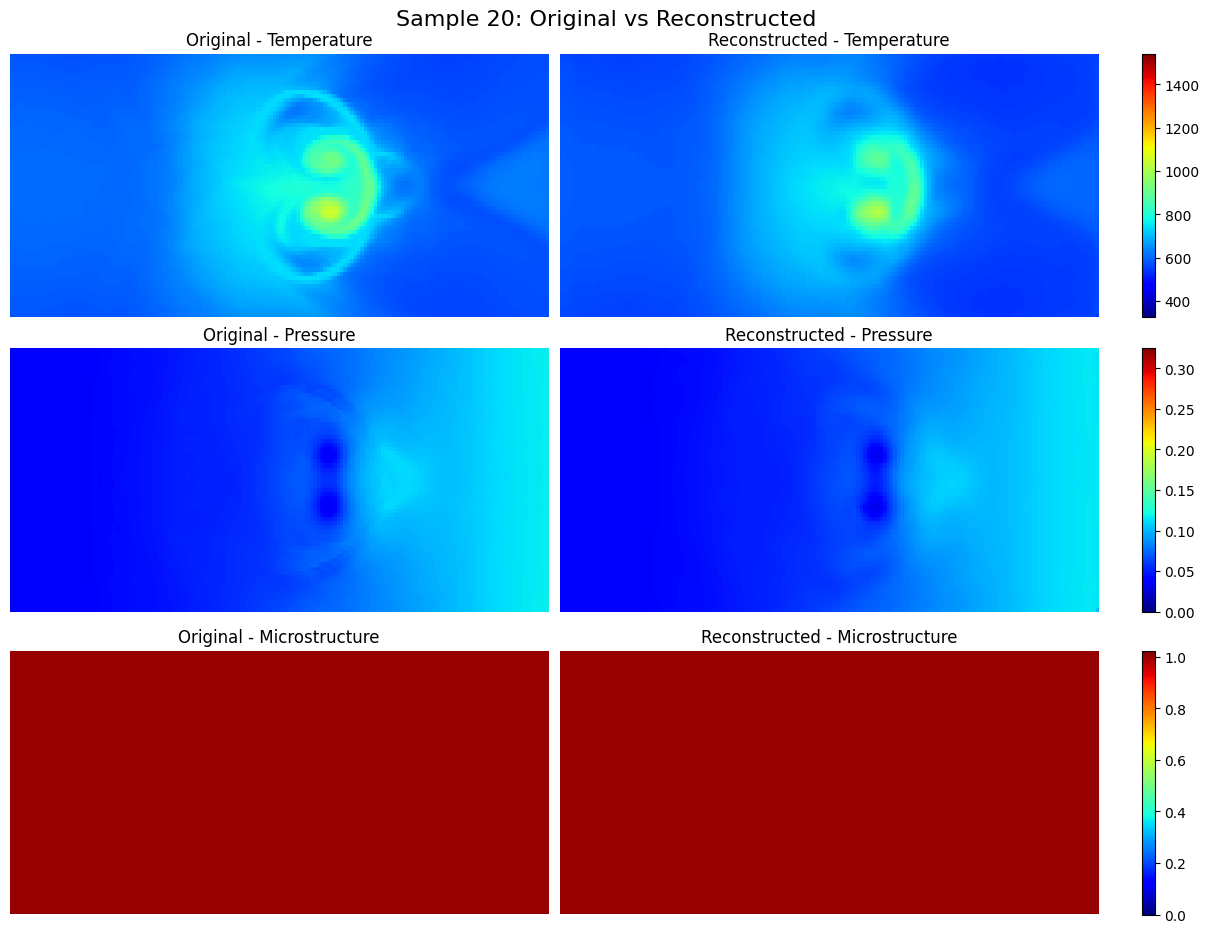

In [9]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"] # u and v

num_ts = 20 

visualize_denorm_reconstructions(
    X=X_denorm,
    reconstructions=pred_denorm,
    channel_names=channel_names,
    num_ts=num_ts,
    clamp_01=False
)

### GIF

In [10]:
generate_denorm_prediction_comparison_gif(
    X=X_denorm[:,:3,...],
    prediction=pred_denorm[:,:3,...],
    channel_names=["Temperature", "Pressure", "Microstructure"],
    file_name=f"sample{sample_id}_{weights_name}_denorm",
    plot_title="LatentPARC Rollout Prediction",
    color_scheme="jet",
    clamp_01=False
)

GIF saved to sample17_large_LP_3000_denorm.gif


### Quantitative Analysis

In [11]:
# just T channel, reshape to [n_train, nt, ny, nx], not tensor anymore
ground_truth = X_denorm[:, 0, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()
X_pred = pred_denorm[:, 0, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()

# just ms channel, reshape to [n_train, nt, ny, nx], not tensor anymore
ground_truth_MS = X_denorm[:, 2, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()
X_pred_MS = pred_denorm[:, 2, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()

In [12]:
# ASK KEVIN
dx = 1.0 # in preprocessing.ipynb dx = 1.0 / np.sum(np.ones(xg_bnd.shape))
dy = 1.0
test_params = np.array([1, 1, 1, 1, 1]) # I think this is just for extracting case number for save name
nt = 20 # pretty sure this is just number of timesteps
dt = 0.01

In [13]:
Xerror = np.abs(ground_truth - X_pred)
rel_error = np.sum(Xerror ** 2, axis=(2, 3)) / np.sum(ground_truth ** 2, axis=(2, 3))
rel_error = np.sqrt(rel_error)
max_relerror = rel_error.max(-1)

Tmax_truth = np.max(ground_truth, axis=(2, 3))
Tmax_pred = np.max(X_pred, axis=(2, 3))
# print(Tmax_truth)
# print(Tmax_pred)
# Tmax_error = np.abs(Tmax_pred - Tmax_truth) / Tmax_truth
Thre = 800.
hotspot_truth = np.sum(ground_truth > Thre, axis=(2, 3)) * dx * dy * 1e6
hotspot_pred = np.sum(X_pred > Thre, axis=(2, 3)) * dx * dy * 1e6
hotspot_error = np.abs(hotspot_pred - hotspot_truth) / (hotspot_truth + 1e-6) # ADDED THIS BC DIV BY 0
# hotspot_maxerror = hotspot_error.max(-1)

mask_pred = (X_pred_MS < 0.5)
mask_truth = (ground_truth_MS < 0.5)
pore_truth = np.sum(mask_truth, axis=(2, 3)) * dx * dy * 1e6
pore_pred = np.sum(mask_pred, axis=(2, 3)) * dx * dy * 1e6

idx = test_params.shape[0] - 5

time = np.linspace(0, (nt-1) * dt, nt)

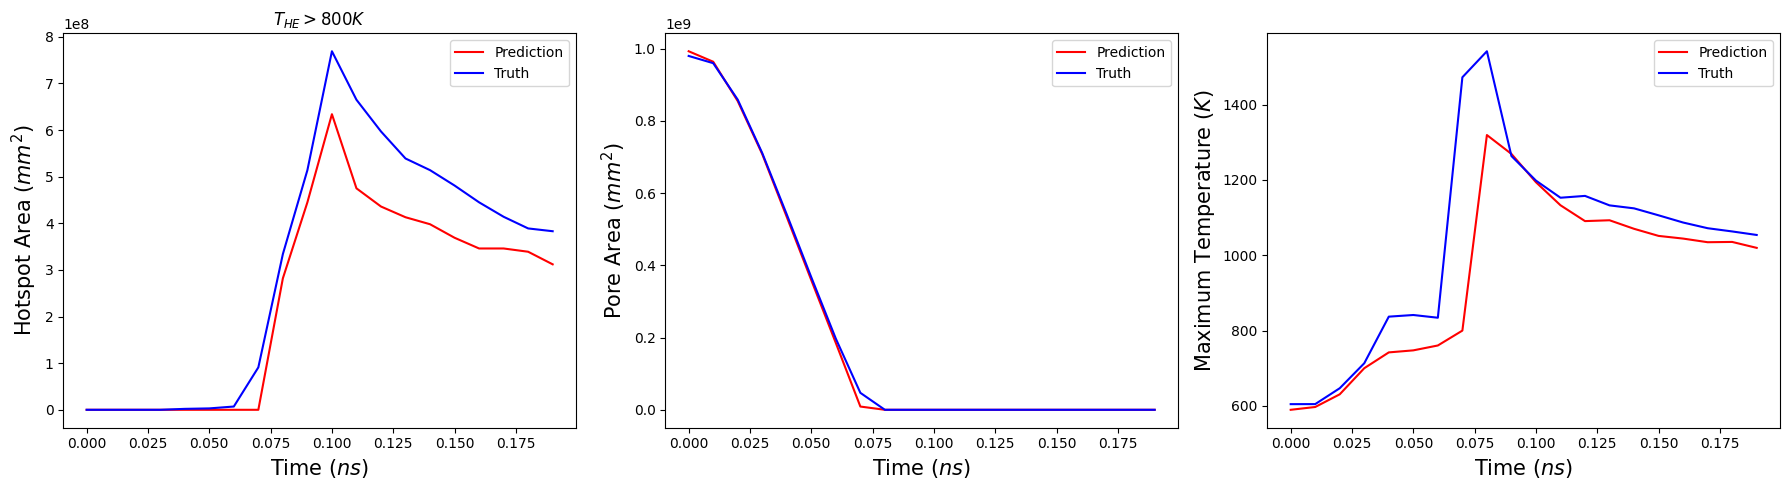

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# --- Plot 1: Hotspot Area ---
axes[0].plot(time, hotspot_pred[idx], '-r')
axes[0].plot(time, hotspot_truth[idx], '-b')
axes[0].set_xlabel('Time ($ns$)', fontsize=15)
axes[0].set_ylabel('Hotspot Area ($mm^2$)', fontsize=15)
axes[0].set_title('$T_{HE} > 800K$')
axes[0].legend(['Prediction', 'Truth'])

# --- Plot 2: Pore Area ---
axes[1].plot(time, pore_pred[idx], '-r')
axes[1].plot(time, pore_truth[idx], '-b')
axes[1].set_xlabel('Time ($ns$)', fontsize=15)
axes[1].set_ylabel('Pore Area ($mm^2$)', fontsize=15)
axes[1].legend(['Prediction', 'Truth'])

# --- Plot 3: Maximum Temperature ---
axes[2].plot(time, Tmax_pred[idx], '-r')
axes[2].plot(time, Tmax_truth[idx], '-b')
axes[2].set_xlabel('Time ($ns$)', fontsize=15)
axes[2].set_ylabel('Maximum Temperature ($K$)', fontsize=15)
axes[2].legend(['Prediction', 'Truth'])

fig.tight_layout()

# Optional save
# fig.savefig('%s.test.summary.case%d.%s.png' % (name, idx, data_dir), dpi=200)

filename = f"sample{sample_id}_{weights_name}_quantmetrics.png"
fig.savefig(filename, dpi=200) # , bbox_inches="tight"


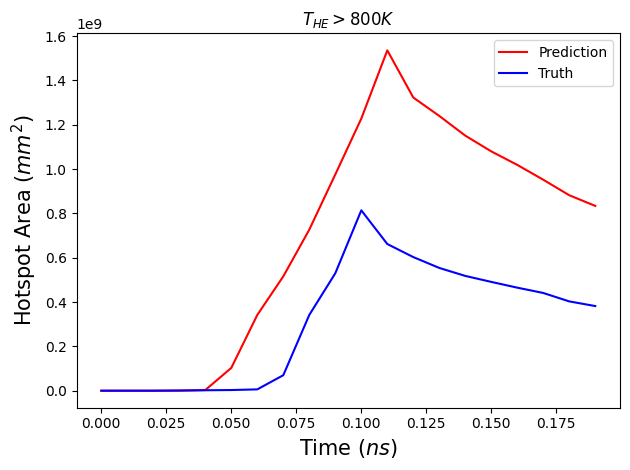

In [18]:
fig = plt.figure(1)
ax = plt.axes()
plt.plot(time, hotspot_pred[idx], '-r')
plt.plot(time, hotspot_truth[idx], '-b')
ax.set_xlabel('Time ($ns$)', fontsize=15)
ax.set_ylabel('Hotspot Area ($mm^2$)', fontsize=15)
ax.set_title('$T_{HE}>800K$')
plt.legend(['Prediction', 'Truth'])
fig.tight_layout()
# fig.savefig('%s.test.hotspot.case%d.%s.png' % (name, idx, data_dir), dpi=200)


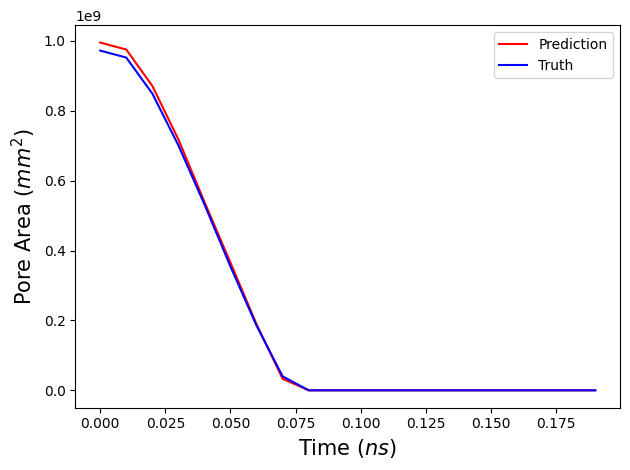

In [19]:
fig = plt.figure(2)
ax = plt.axes()
plt.plot(time, pore_pred[idx], '-r')
plt.plot(time, pore_truth[idx], '-b')
ax.set_xlabel('Time ($ns$)', fontsize=15)
ax.set_ylabel('Pore Area ($mm^2$)', fontsize=15)
plt.legend(['Prediction', 'Truth'])
fig.tight_layout()
# fig.savefig('%s.test.pore.case%d.%s.png' % (name, idx, data_dir), dpi=200)


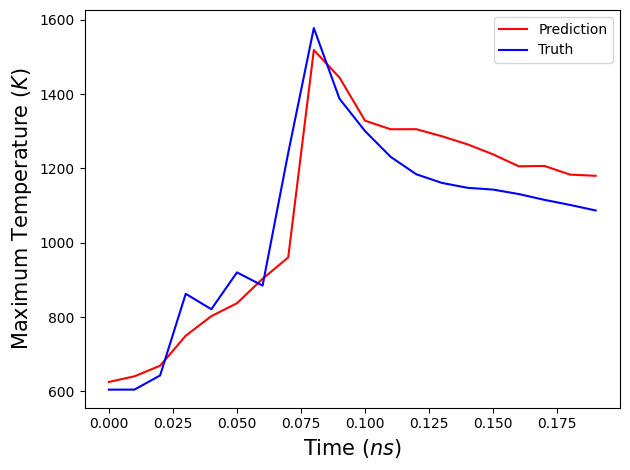

In [20]:
fig = plt.figure(3)
ax = plt.axes()
plt.plot(time, Tmax_pred[idx], '-r')
plt.plot(time, Tmax_truth[idx], '-b')
ax.set_xlabel('Time ($ns$)', fontsize=15)
ax.set_ylabel('Maximum Temperature ($K$)', fontsize=15)
plt.legend(['Prediction', 'Truth'])
fig.tight_layout()
# fig.savefig('%s.test.Tmax.case%d.%s.png' % (name, idx, data_dir), dpi=200)
